In [147]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

from cassL import camb_interface as ci
from cassL import generate_emu_data as ged
from cassL import user_interface as ui

pb.ion()

file_base = ""

In [148]:
#X_raw = np.load("G_versions/hc_G6_test.npy", allow_pickle=True)
#Y_raw = np.load("G_versions/samples_G6_test.npy", allow_pickle=True)
linear_in_sigma12 = True

if linear_in_sigma12:
    X_raw = np.load("hc_backup_i99_H3_unit_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i99_H3_unit_train.npy", allow_pickle=True)
else:
    X_raw = np.load("hc_backup_i499_H2_train.npy", allow_pickle=True)
    Y_raw = np.load("samples_backup_i499_H2_train.npy", allow_pickle=True)    

# Emulator version label, for plots
emu_vlabel = "H3"

In [149]:
scales = np.load("standard_k.npy", allow_pickle=True)

In [150]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [151]:
m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".cle", "rb"))

In [152]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [153]:
par_ranges = ui.get_param_ranges(massive_neutrinos=True)
xmin = np.array([])
xrange = np.array([])

for key in par_ranges.keys():
    xmin = np.append(xmin, par_ranges[key][0])
    xrange = np.append(xrange, par_ranges[key][1] - par_ranges[key][0])

# ! This is bad form, xmin and xrange should be saved with the emulator object
#def xtransform(configuration):
#    return (configuration - xmin) / xrange

def xtransform(configuration):
    return configuration

In [154]:
def nest(array):
    return np.array([np.array(array)])

In [155]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = (preds[i] - Y[i]) / Y[i]
    sq_errors[i] = np.square(preds[i] - Y[i])

In [156]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
9.718994267260946


# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [157]:
min(X[:, 3])

0.012899999998143667

In [158]:
max(X[:, 3])

0.9987007241067299

In [159]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

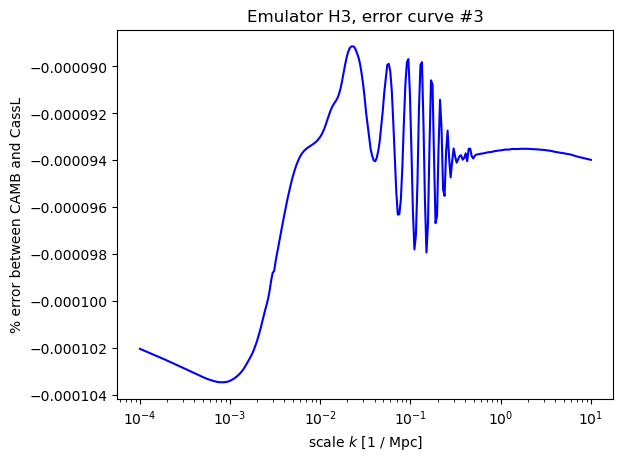

In [160]:
error_i = 3
pb.plot(scales, 100 * rel_errors[error_i], color='blue')
pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", error curve #" + str(error_i))
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G7a.png")

In [161]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, save_label=None):
    normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)

    for i in range(len(rel_errors)):
        if i % 1 == 0:
            pb.plot(scales, 100 * rel_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" + 
            "\ncolored by " + param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index]), vmax=max(X[:, param_index]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../plots/emulator/performance/" + save_label + ".png")

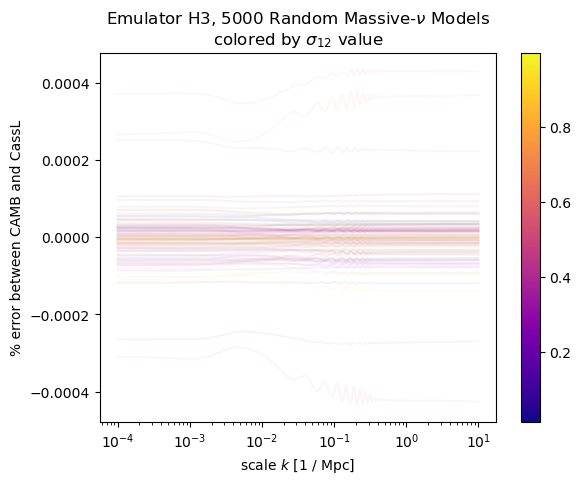

In [162]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label="s12_coloration")

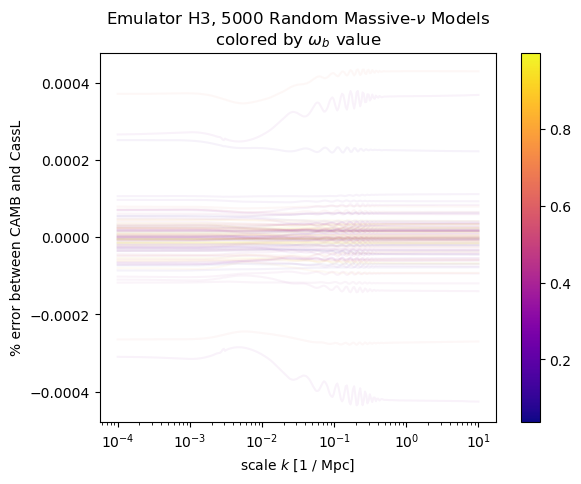

In [163]:
plot_colored_errors(0, r"$\omega_b$")

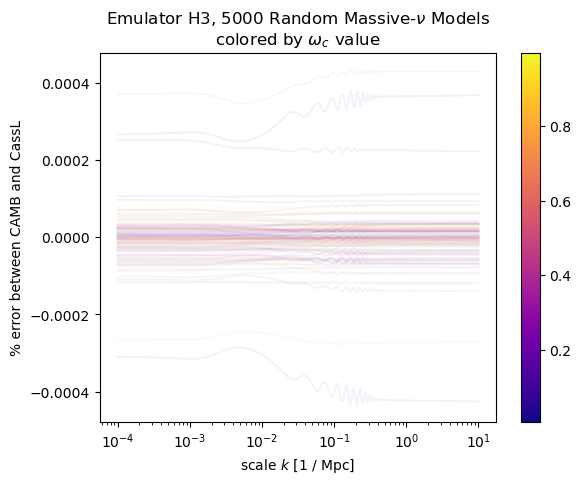

In [164]:
plot_colored_errors(1, r"$\omega_c$")

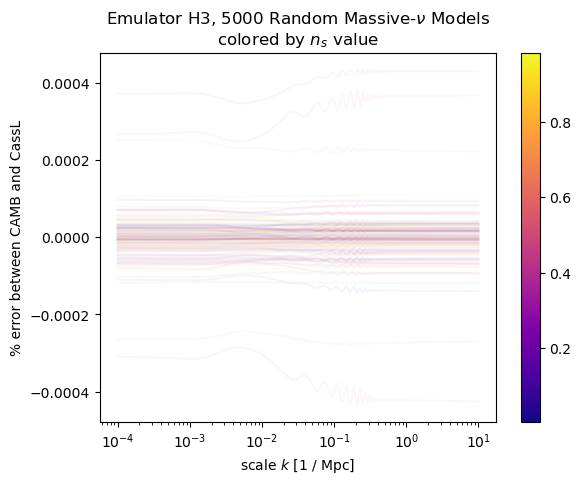

In [165]:
plot_colored_errors(2, r"$n_s$")

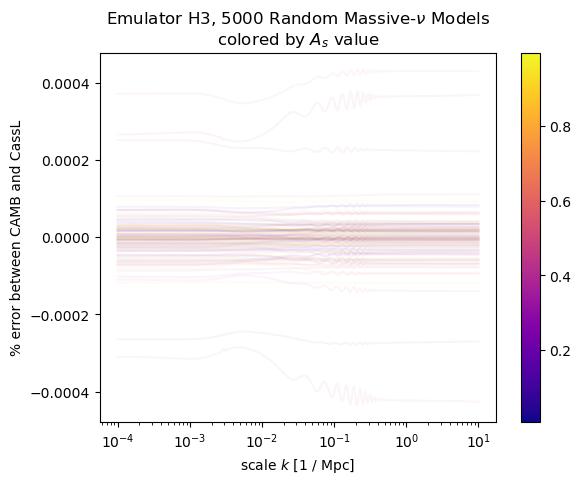

In [166]:
plot_colored_errors(4, r"$A_s$", "_colored_by_As")

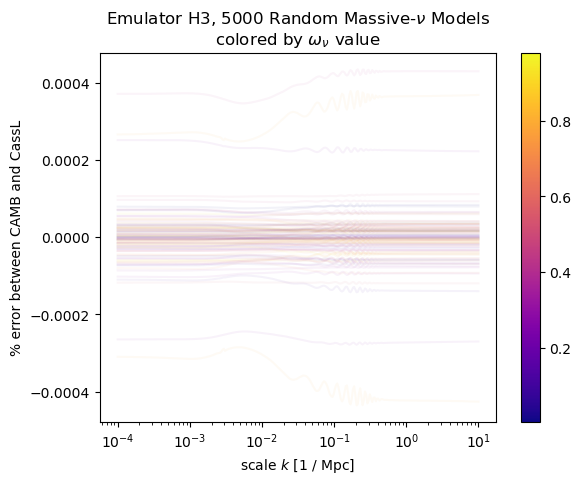

In [167]:
plot_colored_errors(5, r"$\omega_\nu$", "_colored_by_omnu")

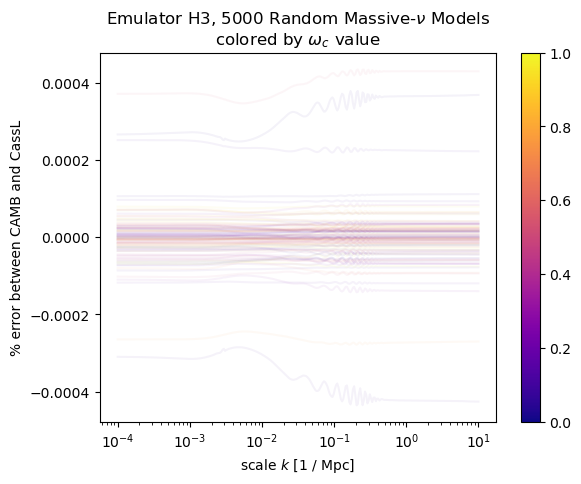

In [168]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

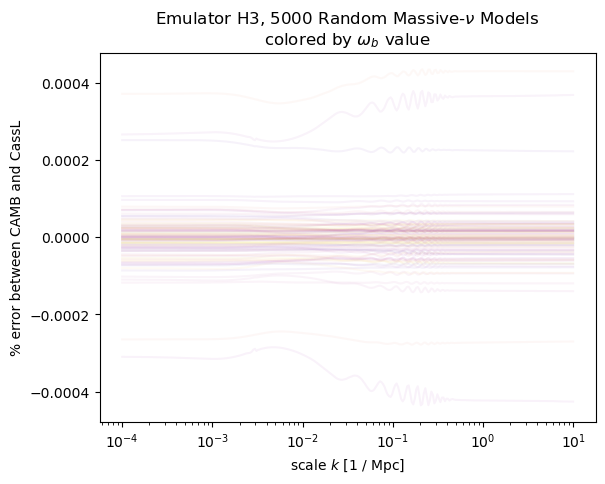

In [169]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

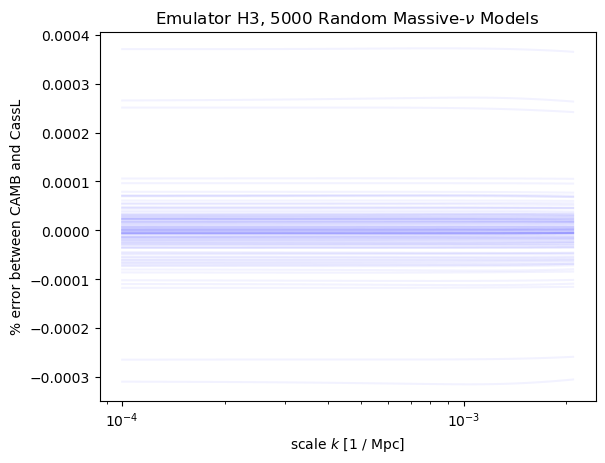

In [170]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

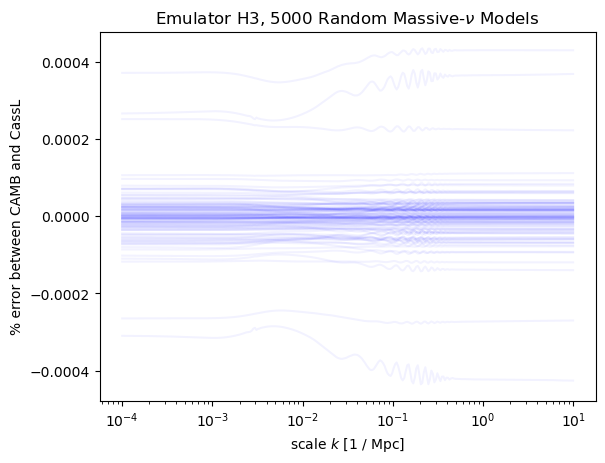

In [171]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../plots/emulator/performance/massive_5k_" + emu_vlabel + ".png")

In [172]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 1.5368139084074078e-11 to 3.461498820253497e-06
median is 1.8204497497588953e-07
mean is 3.8926851982726094e-07
st.dev. is 5.947355073861055e-07


In [173]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 3.021042303152176e-08 to 4.34994824855715e-06
median is 2.840297279944325e-07
mean is 5.252424151132443e-07
st.dev. is 7.732727317609833e-07


In [174]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -3.6178576616218405e-06 to 3.9532933556818095e-06
median is -3.952566508214028e-09
mean is 6.712209341898925e-11
st.dev. is 8.25348244477574e-07


In [175]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -3.6402521398539107e-06 to 3.944611478799171e-06
median is -6.609283935605456e-09
mean is -7.073880039618711e-10
st.dev. is 8.238967270664837e-07


In [176]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 2.0520156806558267e-09 to 5.341867734068249e-07
median is 2.8680090444862903e-08
mean is 4.790406030022991e-08
st.dev. is 7.589431565540188e-08


(array([69., 19.,  5.,  2.,  0.,  0.,  1.,  2.,  1.,  1.]),
 array([1.53681391e-11, 3.46163713e-07, 6.92312059e-07, 1.03846040e-06,
        1.38460875e-06, 1.73075709e-06, 2.07690544e-06, 2.42305378e-06,
        2.76920213e-06, 3.11535048e-06, 3.46149882e-06]),
 <BarContainer object of 10 artists>)

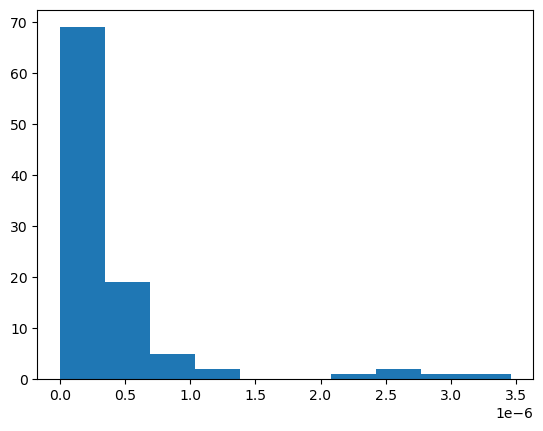

In [177]:
pb.hist(mins)

(array([68., 21.,  5.,  1.,  0.,  1.,  1.,  0.,  1.,  2.]),
 array([3.02104230e-08, 4.62184206e-07, 8.94157988e-07, 1.32613177e-06,
        1.75810555e-06, 2.19007934e-06, 2.62205312e-06, 3.05402690e-06,
        3.48600068e-06, 3.91797447e-06, 4.34994825e-06]),
 <BarContainer object of 10 artists>)

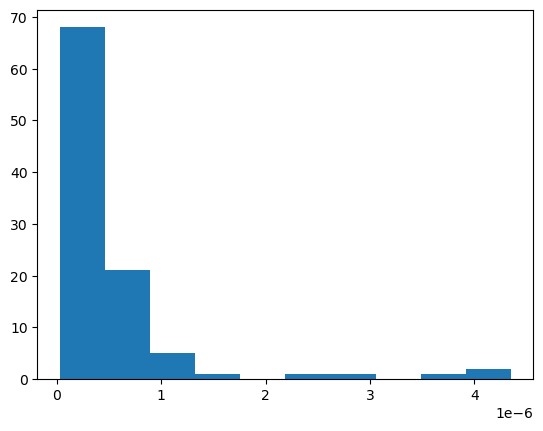

In [178]:
pb.hist(maxs)

(array([81., 12.,  4.,  0.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([2.05201568e-09, 5.52654915e-08, 1.08478967e-07, 1.61692443e-07,
        2.14905919e-07, 2.68119395e-07, 3.21332870e-07, 3.74546346e-07,
        4.27759822e-07, 4.80973298e-07, 5.34186773e-07]),
 <BarContainer object of 10 artists>)

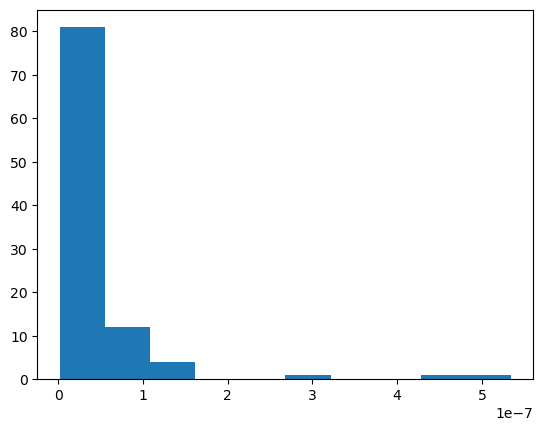

In [179]:
pb.hist(stddevs)

(array([ 1.,  1.,  0.,  8., 55., 30.,  2.,  1.,  1.,  1.]),
 array([-3.64025214e-06, -2.88176578e-06, -2.12327942e-06, -1.36479305e-06,
        -6.06306692e-07,  1.52179669e-07,  9.10666031e-07,  1.66915239e-06,
         2.42763876e-06,  3.18612512e-06,  3.94461148e-06]),
 <BarContainer object of 10 artists>)

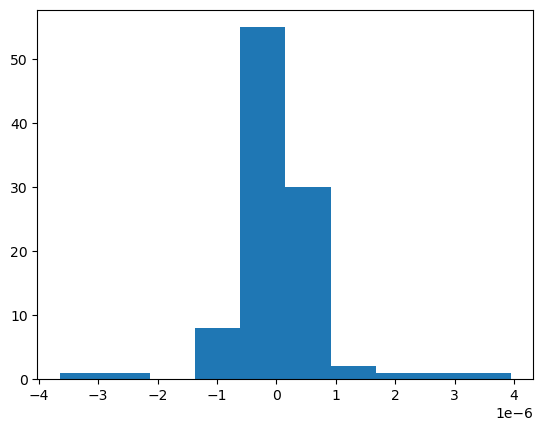

In [180]:
pb.hist(meds)

(array([ 1.,  1.,  0., 11., 52., 30.,  2.,  1.,  1.,  1.]),
 array([-3.61785766e-06, -2.86074256e-06, -2.10362746e-06, -1.34651236e-06,
        -5.89397255e-07,  1.67717847e-07,  9.24832949e-07,  1.68194805e-06,
         2.43906315e-06,  3.19617825e-06,  3.95329336e-06]),
 <BarContainer object of 10 artists>)

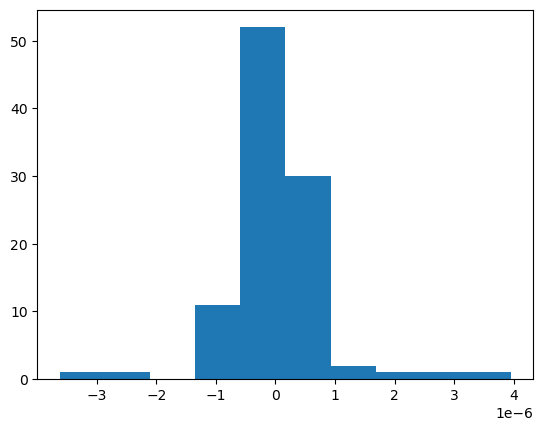

In [181]:
pb.hist(means)